In [ ]:
from tensorflow.python.keras.applications.densenet import DenseNet121, decode_predictions, preprocess_input
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(...)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(...)

In [1]:
import numpy as np
import tensorflow as tf

# Note that we load the model without any fully connected layers,
# since we do no need them in this notebook.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
feature_extractor = model.layers[:7]
feature_extractor

In [4]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

classifier = [
    GlobalAveragePooling2D(),
    Dense(
        units=128, 
        activation='relu'
    ),
    Dense(
        units=10, 
        activation='softmax'
    )
]

In [5]:
layers = feature_extractor + classifier
layers

In [6]:
from tensorflow.keras.models import Sequential
model = Sequential(feature_extractor + classifier)

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
__________

In [8]:
import pandas as pd

dataset_id = '20190927-233244_3a66bfb023d40470edbcf174694d0595'
prefix = f'https://ucla-deeplearning.s3-us-west-1.amazonaws.com/storage/mnist-0.2/jobs/transform_repack/{dataset_id}'
train_clean_X = pd.read_parquet(f'{prefix}/train_clean_X.parquet')
validate_clean_X = pd.read_parquet(f'{prefix}/validate_clean_X.parquet')
test_clean_X = pd.read_parquet(f'{prefix}/test_clean_X.parquet')
train_y = pd.read_parquet(f'{prefix}/train_y.parquet')
validate_y = pd.read_parquet(f'{prefix}/validate_y.parquet')
test_y = pd.read_parquet(f'{prefix}/test_y.parquet')

/opt/conda/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/opt/conda/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/opt/conda/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [11]:
from utils import crop_and_resize_for_imagenet
from PIL import Image

train_X = train_clean_X.values.reshape(-1, 28, 28)
train_X = np.array([
    crop_and_resize_for_imagenet(Image.fromarray((image * 255).astype('uint8')))
    for image in train_X[:100]
])
train_X = np.expand_dims(train_X, 3)
train_X = np.repeat(train_X, 3, axis=3)
train_X.shape

(100, 224, 224, 3)

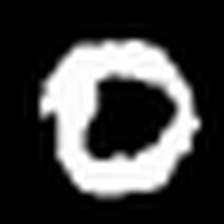

In [12]:
Image.fromarray(train_X[0])

In [24]:
from keras.utils import to_categorical
train_y_hot = to_categorical(train_y.values.ravel())
train_y.values.ravel().shape, train_y_hot.shape
train_y[:10]

,digit
0,0.000000
1,0.011765
2,0.031373
3,0.035294
4,0.003922
5,0.019608
6,0.003922
7,0.007843
8,0.000000
9,0.019608


In [17]:
for layer in feature_extractor:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy'
)

model.fit(
    x=train_X,
    y=train_y_hot[:100],
    epochs=2
)

ValueError: You are passing a target array of shape (100, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.